In [1]:
import pandas as pd
import numpy as np
# from sklearn.linear_model import Ridge
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
# import matplotlib.pyplot as plt
import xgboost as xgb
import re

### I Méthode Holdout

In [9]:
# On pourra aussi utiliser "df_for_cv_o_n.pkl"
# df_for_cv_interaction_and_dummies = pd.read_pickle("df_for_cv_interaction_and_dummies.pkl")

# OU 

df_for_cv_used = pd.read_pickle("../data/df_train_for_cv_o_n_sk_mean_encoding_1.pkl")

all_var_x = [each for each in list(df_for_cv_used) if each != "count" and each != "datetime"]

# df_for_cv_interaction_and_dummies.shape
X_train = df_for_cv_used[all_var_x]
Y_train = df_for_cv_used[["count"]]

Exclusion des variables Quartiles et des variables "Special"

In [10]:
X_train.shape

(10886, 15)

In [11]:
list(X_train)

['CN_school',
 'NN_soleil',
 'NN_tendance_1',
 'NN_tendance_2',
 'NO_atemp',
 'NO_humidity',
 'NO_temp',
 'NO_windspeed',
 'CO_hour_mean_encoding',
 'CO_month_mean_encoding',
 'CO_day_mean_encoding',
 'CO_weather_ordinal_encoding',
 'CO_season_ordinal_encoding',
 'CO_year_ordinal_encoding',
 'CN_type_of_day']

In [27]:
# variables_to_keep = [each for each in list(X_train) if each[0] != 'S' and each[-1] != 'Q']
# X_train = X_train[variables_to_keep]

### Petit processing sur le nom des features

In [4]:
# features_names = list(X_train)
# new_features_names = [re.sub("\[|\]|\<|\>",'',line) for line in features_names]
# X_train.columns = new_features_names

## XGBoost valeurs par défaut

In [4]:
X_train.shape

(10886, 15)

In [5]:
# Calcul des Y = log(Y + 1)
Y_train['log_count'] = Y_train['count'].map(lambda x: np.log1p(x))
Y_train = Y_train.drop("count", axis = 1)

/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Création "train" + "validation" = méthode Holdout

In [7]:
X_train.shape

(10886, 15)

In [47]:
Y_train.sample(n=2)

,log_count
4311,5.771441
8901,5.075174


In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train,
                                                    Y_train,
                                                    test_size = 0.3,
                                                    random_state = 0)

In [9]:
X_test.shape

(3266, 15)

In [ ]:
# On exclue : NN_soleil, NN_tendance_1 et NN_tendance_2 ?
# var_to_keep = [var_name for each in list(X_train)]
# X_train = X_train[var_to_keep]

In [ ]:
On essaye suivant les conseils du MOOC:
- on n'utilise pas Gamma
- on fixe Max_depth = 7, on peut l'augmenter tant qu'on ne fait pas 
  du sur-apprentissag, de manière à obtenir un meilleur modèle
- on prend Subsample entre 0 et 1 (le diminuer pour faire moins
  de sur-apprentissage)
- Pour Colsample_bytree, le diminuer si il y a sur-apprentissage
- min_child_weight: le faire bcp varier avec 0,5,15,300
  car il va permettre d'avoir un modèle plus contraint
  et donc de lutter contre le sur-apprentissage
- Eta : entre 0.01 et 0.1
- Num_rounds: le prendre élévé, Num_rounds = n_estimators ?
  On peut augmenter Num_rounds jusqu'à ce que l'erreur augmente trop
  sur le validation set (early stopping)
    
- Astuce : multiplier par un facteur de alpha Num_rounds et diviser par ce facteur
  de alpha la valeur de Eta

In [56]:
%%time
n_iter=85

df_result_models = pd.DataFrame(columns = ['colsample_bytree','learning_rate','max_depth','n_estimators','subsample','min_child_weight','RMSE_train','RMSE_test'])
# df_result_models = pd.DataFrame(columns = ['colsample_bytree','gamma','learning_rate','max_depth','n_estimators','subsample','reg_lambda','RMSE_train','RMSE_test'])

for each in range(1,n_iter):
    
    # print ("Modèle n°", each)
    colsample_bytree_value = np.random.uniform(0.3,0.7)
    
    # gamma_value = np.random.uniform(0, 0.5)
    # learning_rate_value = np.random.uniform(0.03, 0.3)
    learning_rate_value = np.random.uniform(0.01, 0.1)
    # max_depth_value = np.random.randint(2, 6)
    
    max_depth_value = np.random.randint(7,20)
    
    # n_estimators_value = np.random.randint(100, 150)
    n_estimators_value = np.random.randint(400, 500)
    # n_estimators_value = np.random.randint(400, 5000)
    # subsample_value = np.random.uniform(0.4, 0.6)
    subsample_value = np.random.uniform(0,1)
    
    # reg_alpha_value = np.random.uniform(0, 0.05)
    # reg_alpha_value = np.random.uniform(0, 10)
    # reg_lambda_value = np.random.uniform(0, 10)
    # reg_lambda_value = np.random.uniform(5, 20)
    
    # print ("max_depth", max_depth_value)
    
    min_child_weight_value = np.random.randint(0,300)
    
    xgb_model = xgb.XGBRegressor(
        colsample_bytree = colsample_bytree_value,
        # gamma = gamma_value,
        learning_rate = learning_rate_value,
        max_depth = max_depth_value,
        n_estimators = n_estimators_value,
        subsample = subsample_value,
        # reg_alpha = reg_alpha_value,
        # reg_lambda = reg_lambda_value,
        n_jobs = 4,
        min_child_weight = min_child_weight_value,
        objective="reg:squarederror")
        
        # eval_metric = "rmse"
          
    result = xgb_model.fit(X_train, Y_train)
    
    predicted_values = xgb_model.predict(X_train)
    # print ("predicted_values", predicted_values)
    predicted_values = np.expand_dims(predicted_values, axis=1)
        
    RMSE_train_value = np.sqrt(np.mean((predicted_values - Y_train.values)**2, axis=0))
    # print("le score RMLSE sur le training set vaut : {}".format(RMSE))
    
    predicted_values = xgb_model.predict(X_test)
    predicted_values = np.expand_dims(predicted_values, axis=1)
        
    RMSE_test_value = np.sqrt(np.mean((predicted_values - Y_test.values)**2, axis=0))
    # print("le score RMSE sur le test set vaut : {}".format(RMSE))
    
    if RMSE_train_value != None and RMSE_test_value != None:
    
        df_result_models = df_result_models.append({'colsample_bytree': colsample_bytree_value, 
                                 # 'gamma':gamma_value,
                                 'learning_rate':learning_rate_value,
                                 'max_depth':max_depth_value,
                                 'n_estimators':n_estimators_value,
                                 'subsample':subsample_value,
                                 # 'reg_alpha':reg_alpha_value,
                                 # 'reg_lambda':reg_lambda_value,
                                  'min_child_weight':min_child_weight_value,                 
                                 'RMSE_train':RMSE_train_value,
                                 'RMSE_test':RMSE_test_value}, ignore_index= True)

CPU times: user 11min 1s, sys: 6.96 s, total: 11min 8s
Wall time: 2min 54s


In [55]:
df_result_models[df_result_models["RMSE_test"]  == df_result_models["RMSE_test"].min()[0]]

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,min_child_weight,RMSE_train,RMSE_test
71,0.680614,0.075019,7,405,0.849547,36,[0.26218596494599156],[0.3953321459408146]


In [ ]:
Apres augmentation possible de Max_depth
on voit qu'il a fait trop de sur-apprentissage

In [57]:
df_result_models[df_result_models["RMSE_test"]  == df_result_models["RMSE_test"].min()[0]]

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,min_child_weight,RMSE_train,RMSE_test
40,0.615728,0.065323,17,463,0.964829,45,[0.20435072669458268],[0.39354724788020523]


On re-teste cette fois en utilisant "reg_lambda"

In [116]:
n_iter=85

df_result_models = pd.DataFrame(columns = 
['colsample_bytree','learning_rate','max_depth','n_estimators','subsample','reg_lambda','min_child_weight','RMSE_train','RMSE_test'])


for each in range(1,n_iter):
    
    # print ("Modèle n°", each)
    colsample_bytree_value = np.random.uniform(0.3,0.7)
    
    # gamma_value = np.random.uniform(0, 0.5)
    # learning_rate_value = np.random.uniform(0.03, 0.3)
    learning_rate_value = np.random.uniform(0.01, 0.1)
    # max_depth_value = np.random.randint(2, 6)
    
    max_depth_value = np.random.randint(7,20)
    
    # n_estimators_value = np.random.randint(100, 150)
    n_estimators_value = np.random.randint(400, 500)
    # n_estimators_value = np.random.randint(400, 5000)
    # subsample_value = np.random.uniform(0.4, 0.6)
    subsample_value = np.random.uniform(0,1)
    
    # reg_alpha_value = np.random.uniform(0, 0.05)
    # reg_alpha_value = np.random.uniform(0, 10)
    # reg_lambda_value = np.random.uniform(0, 10)
    reg_lambda_value = np.random.uniform(5, 20)
    
    # print ("max_depth", max_depth_value)
    
    min_child_weight_value = np.random.randint(0,300)
    
    xgb_model = xgb.XGBRegressor(
        colsample_bytree = colsample_bytree_value,
        # gamma = gamma_value,
        learning_rate = learning_rate_value,
        max_depth = max_depth_value,
        n_estimators = n_estimators_value,
        subsample = subsample_value,
        # reg_alpha = reg_alpha_value,
        # reg_lambda = reg_lambda_value,
        n_jobs = 4,
        reg_lambda = reg_lambda_value,
        min_child_weight = min_child_weight_value,
        objective="reg:squarederror")
        
        # eval_metric = "rmse"
          
    result = xgb_model.fit(X_train, Y_train)
    
    predicted_values = xgb_model.predict(X_train)
    # print ("predicted_values", predicted_values)
    predicted_values = np.expand_dims(predicted_values, axis=1)
        
    RMSE_train_value = np.sqrt(np.mean((predicted_values - Y_train.values)**2, axis=0))
    # print("le score RMLSE sur le training set vaut : {}".format(RMSE))
    
    predicted_values = xgb_model.predict(X_test)
    predicted_values = np.expand_dims(predicted_values, axis=1)
        
    RMSE_test_value = np.sqrt(np.mean((predicted_values - Y_test.values)**2, axis=0))
    # print("le score RMSE sur le test set vaut : {}".format(RMSE))
    
    if RMSE_train_value != None and RMSE_test_value != None:
    
        df_result_models = df_result_models.append({'colsample_bytree': colsample_bytree_value, 
                                 # 'gamma':gamma_value,
                                 'learning_rate':learning_rate_value,
                                 'max_depth':max_depth_value,
                                 'n_estimators':n_estimators_value,
                                 'subsample':subsample_value,
                                 # 'reg_alpha':reg_alpha_value,
                                 'reg_lambda':reg_lambda_value,
                                'min_child_weight':min_child_weight_value,                 
                                 'RMSE_train':RMSE_train_value,
                                 'RMSE_test':RMSE_test_value}, ignore_index= True)

In [117]:
df_result_models[df_result_models["RMSE_test"]  == df_result_models["RMSE_test"].min()[0]]

,colsample_bytree,learning_rate,max_depth,n_estimators,subsample,reg_lambda,min_child_weight,RMSE_train,RMSE_test
80,0.635844,0.088452,16,420,0.814229,10.293979,71,[0.24679116548750935],[0.39590644208833703]


Cette fois, on fixe les hyperparamètres

In [ ]:
On revient avec Max_depth = 7
diminuer un peu Subsample = 0.5 KO car sur-apprentissage 
je remets 0.849547
diminuer un peu Colsample_bytree = 0.5 KO car sur-apprentissage
je remets 0.680614

On essage n_estimators = 1000 KO car sur-apprentissage
0.19 et 0.3979
On essaye 800 grace au trick ci-dessous:
learning_rate vs n_estimators
- On multiplie par 2 n_estimators
- On divise par 2 learning_rate

On re-essaye:
- On multiplie par 4 n_estimators : n_estimators = 1600
- On divise par 4 learning_rate:learning_rate = 0.0175

In [ ]:
random_state = 25,656,899

In [18]:
%%time
from matplotlib import pyplot
xgb_model = xgb.XGBRegressor(
        colsample_bytree = 0.680614,
        # learning_rate = 0.075019,
        # learning_rate = 0.0375095,
        # learning_rate = 0.0175,
        # learning_rate = 0.012,
        # learning_rate = 0.01875475,
        # learning_rate = 0.01250031,
        # learning_rate =0.010717,
        learning_rate = 0.009377379,
        # max_depth = 7,
        # max_depth = 8,
        max_depth = 10,
        # max_depth = 20,
        # n_estimators = 1000,
        # n_estimators = 400,
        # n_estimators = 800,
        # n_estimators = 1600,
        # n_estimators = 2400,
        #  n_estimators = 2800,
        n_estimators = 10000,
        # n_estimators = 3200,
        # n_estimators = 1600,
        # n_estimators = 5000,
        # n_estimators = 10000,
        # n_estimators = 405,
        # n_estimators = 405,
        subsample = 0.849547,
        n_jobs = 4,
        min_child_weight = 36,
        # min_child_weight = 50,
        # min_child_weight = 100,
        # reg_lambda = 5,
        reg_lambda = 10,
        # reg_lambda = 15,
        # reg_lambda = 15,
        # reg_lambda = 17,
        # random_state = 25,656,899
        # random_state = 899,
        objective="reg:squarederror")
        # eval_metric = "rmse"
               

#        DIAGNOSTIC EARLY STOPPING
# eval_set = [(X_test, Y_test)]        
# result = xgb_model.fit(X_train, Y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

eval_set = [(X_train, Y_train), (X_test, Y_test)]
xgb_model.fit(X_train, Y_train, eval_metric= "rmse", eval_set=eval_set, verbose=False)

CPU times: user 4min 29s, sys: 1.11 s, total: 4min 30s
Wall time: 1min 8s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.680614, gamma=0,
             importance_type='gain', learning_rate=0.009377379,
             max_delta_step=0, max_depth=10, min_child_weight=36, missing=None,
             n_estimators=10000, n_jobs=4, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=10, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.849547, verbosity=1)

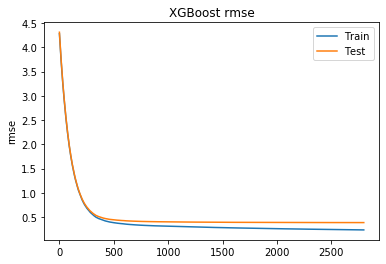

In [10]:
# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()

In [31]:
#for i in range(2000,3000):
    # print (results['validation_1']['rmse'][i])

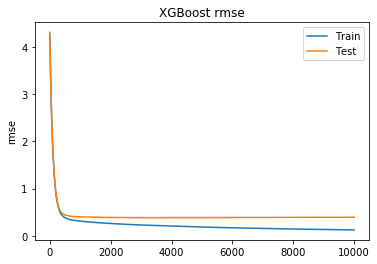

In [19]:
# retrieve performance metrics
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot rmse
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
pyplot.ylabel('rmse')
pyplot.title('XGBoost rmse')
pyplot.show()

In [34]:
%%time
from matplotlib import pyplot
xgb_model = xgb.XGBRegressor(
        colsample_bytree = 0.680614,
        # learning_rate = 0.075019,
        # learning_rate = 0.0375095,
        # learning_rate = 0.0175,
        # learning_rate = 0.012,
        # learning_rate = 0.01875475,
        # learning_rate = 0.01250031,
        # learning_rate =0.010717,
        learning_rate = 0.009377379,
        # max_depth = 7,
        # max_depth = 8,
        max_depth = 10,
        # max_depth = 20,
        # n_estimators = 1000,
        # n_estimators = 400,
        # n_estimators = 800,
        # n_estimators = 1600,
        # n_estimators = 2400,
        n_estimators = 10000,
        # n_estimators = 3200,
        # n_estimators = 1600,
        # n_estimators = 5000,
        # n_estimators = 10000,
        # n_estimators = 405,
        # n_estimators = 405,
        subsample = 0.849547,
        n_jobs = 4,
        min_child_weight = 36,
        # min_child_weight = 50,
        # min_child_weight = 100,
        # reg_lambda = 5,
    
        # reg_lambda = 10,
        reg_lambda = 5,
    
        # reg_lambda = 15,
        # reg_lambda = 15,
        # reg_lambda = 17,
        # random_state = 25,656,899
        # random_state = 899,
        objective="reg:squarederror")
        # eval_metric = "rmse"
               

#        DIAGNOSTIC EARLY STOPPING
# eval_set = [(X_test, Y_test)]        
# result = xgb_model.fit(X_train, Y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)

# eval_set = [(X_train, Y_train), (X_test, Y_test)]
# xgb_model.fit(X_train, Y_train, eval_metric= "rmse", eval_set=eval_set, verbose=True)

eval_set = [(X_test, Y_test)]
xgb_model.fit(X_train, Y_train, early_stopping_rounds=3000, eval_metric="rmse", eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:4.31259
Will train until validation_0-rmse hasn't improved in 3000 rounds.
[1]	validation_0-rmse:4.27421
[2]	validation_0-rmse:4.23566
[3]	validation_0-rmse:4.19743
[4]	validation_0-rmse:4.15966
[5]	validation_0-rmse:4.12264
[6]	validation_0-rmse:4.08594
[7]	validation_0-rmse:4.04891
[8]	validation_0-rmse:4.01241
[9]	validation_0-rmse:3.97617
[10]	validation_0-rmse:3.94093
[11]	validation_0-rmse:3.9062
[12]	validation_0-rmse:3.8717
[13]	validation_0-rmse:3.83734
[14]	validation_0-rmse:3.80332
[15]	validation_0-rmse:3.7697
[16]	validation_0-rmse:3.73662
[17]	validation_0-rmse:3.70377
[18]	validation_0-rmse:3.67263
[19]	validation_0-rmse:3.64031
[20]	validation_0-rmse:3.60752
[21]	validation_0-rmse:3.57588
[22]	validation_0-rmse:3.54405
[23]	validation_0-rmse:3.51242
[24]	validation_0-rmse:3.48284
[25]	validation_0-rmse:3.45221
[26]	validation_0-rmse:3.42193
[27]	validation_0-rmse:3.39197
[28]	validation_0-rmse:3.36166
[29]	validation_0-rmse:3.33179
[30]	validation_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.680614, gamma=0,
             importance_type='gain', learning_rate=0.009377379,
             max_delta_step=0, max_depth=10, min_child_weight=36, missing=None,
             n_estimators=10000, n_jobs=4, nthread=None,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=5, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.849547, verbosity=1)

In [36]:
results['validation_0']['rmse'][3591]
results['validation_1']['rmse'][3591]

0.385991

In [140]:
predicted_values = xgb_model.predict(X_train)
# print ("predicted_values", predicted_values)
predicted_values = np.expand_dims(predicted_values, axis=1)
RMSE_train_value = np.sqrt(np.mean((predicted_values - Y_train.values)**2, axis=0))
# print("le score RMLSE sur le training set vaut : {}".format(RMSE))

predicted_values = xgb_model.predict(X_test)
predicted_values = np.expand_dims(predicted_values, axis=1)
RMSE_test_value = np.sqrt(np.mean((predicted_values - Y_test.values)**2, axis=0))

CPU times: user 1min 18s, sys: 401 ms, total: 1min 19s
Wall time: 20.6 s


In [141]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)

[0.38633697] [0.15125327]


In [ ]:
On teste la fiabilité du modèle Max_depth = 10 et reg_lambda = 10
avec différents seeds : random_state = 25,656,899

In [131]:
# random_state = 25
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.38513005] [0.16184478]

[0.38513005] [0.16184478]


In [133]:
# random_state = 656
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.38535612] [0.16169803]

[0.38535612] [0.16169803]


In [135]:
# random_state = 899
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.38537997] [0.16117823]

[0.38537997] [0.16117823]


In [ ]:
On a Max_depth = 7 et on fait varier "lambda" 

In [112]:
# reg_lambda = 5
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39321539] [0.12607184]

[0.39321539] [0.12607184]


In [114]:
# reg_lambda = 10
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.3916128] [0.12098761]

[0.3916128] [0.12098761]


In [121]:
# reg_lambda = 15
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39190615] [0.11774969]

[0.39190615] [0.11774969]


In [123]:
# reg_lambda = 17
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39214146] [0.11653357]

[0.39214146] [0.11653357]


In [125]:
# Max_depth = 10 et reg_lambda = 5
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.38686236] [0.16856931]

[0.38686236] [0.16856931]


In [127]:
# Max_depth = 10 et reg_lambda = 10
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.38595871] [0.16222409]
# ON SOUMET CE MODELE !!!

[0.38595871] [0.16222409]


In [129]:
# Max_depth = 10 et reg_lambda = 15
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.38610327] [0.15753408]


[0.38610327] [0.15753408]


In [ ]:
Ci-dessous, tests du TRICK "learning_rate vs n_estimators"

In [ ]:
Avec learning_rate = 0.075019 et n_estimators = 400

In [94]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39606559] [0.13223767]

[0.39606559] [0.13223767]


In [ ]:
Avec learning_rate = 0.0375095 et n_estimators = 800

In [96]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39593602] [0.13297401]

[0.39593602] [0.13297401]


In [ ]:
# 0.075019 / 4 = 0.01875
# 400 * 4 = 1600
Avec learning_rate = 0.01875475 et n_estimators = 1600

In [99]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39435971] [0.13294196]

[0.39435971] [0.13294196]


In [ ]:
Avec learning_rate = 0.01250031 et n_estimators = 2400
# 0.075019 / 6 = 0.012
# 400 * 6 = 2400

In [101]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39474074] [0.13231747]

[0.39474074] [0.13231747]


In [ ]:
Avec learning_rate = 0.010717 et n_estimators = 2800

In [103]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39483424] [0.13125106]

[0.39483424] [0.13125106]


In [ ]:
# moins intéressant
Avec learning_rate = 0.009 et n_estimators = 3200

In [109]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.3953402] [0.13286589]

[0.3953402] [0.13286589]


In [ ]:
Avec learning_rate = 0.010717 et n_estimators = 2800
et max_depth= 8

In [105]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.39132764] [0.14910148]

[0.39132764] [0.14910148]


In [ ]:
Avec learning_rate = 0.010717 et n_estimators = 2800
et max_depth= 10

In [107]:
print (RMSE_test_value,RMSE_test_value - RMSE_train_value)
# [0.38919489] [0.17557236]

[0.38919489] [0.17557236]


In [ ]:
On relance Max_depth = 7 + facteur = 7 
avec différents random_state = []
+ soumission
On relance Max_depth = 10 
avec différents random_state = []
+ soumission

In [ ]:
Soumettre ce modèle "learning_rate = 0.010717 et n_estimators = 2800
et max_depth= 10"
versus "learning_rate = 0.010717 et n_estimators = 2800
et max_depth= 7"

#### SAUVEGARDE avec xgb_model

In [142]:
from sklearn.externals import joblib
# pour le save
joblib.dump(xgb_model, "xgb_mean_encoding_1.pkl", compress=9)
# pour le reload
# mymodel = joblib.load("xgb_mean_encoding_1.pkl")

['xgb_mean_encoding_1.pkl']

In [ ]:
PB AVEC REGULARISATION L2 avec lambda = 15 SUR-APPRENTISSAGE
car:
    array([0.17997541]) sur train
    array([0.41278995]) sur valid
On relance avec lambda = 30

In [52]:
RMSE_train_value
#array([0.19464301]) lambda = 30

array([0.19464301])

In [53]:
RMSE_test_value
# array([0.40507004]) lambda = 30

array([0.40507004])

In [57]:
RMSE_train_value
#  avec lambda = 0 et  gamma = 1

array([0.24737289])

In [58]:
RMSE_test_value
# avec lambda = 0 et  gamma = 1

array([0.42305336])

## SAUVEGARDE avec xgb_model

In [32]:
from sklearn.externals import joblib
# pour le save
joblib.dump(xgb_model, "xgb_0.408.pkl", compress=9)
# pour le reload
mymodel = joblib.load("xgb_0.408.pkl")

/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['xgb_0.408.pkl']

In [150]:
df_to_predict = pd.read_pickle("../data/df_test_kaggle_cv_o_n_sk_mean_encoding_1.pkl") 
df_to_predict.shape

(6493, 16)

In [151]:
df_to_predict.sample(n=5)

,CN_school,NN_soleil,NN_tendance_1,NN_tendance_2,NO_atemp,NO_humidity,NO_temp,NO_windspeed,datetime,CO_hour_mean_encoding,CO_month_mean_encoding,CO_day_mean_encoding,CO_weather_ordinal_encoding,CO_season_ordinal_encoding,CO_year_ordinal_encoding,CN_type_of_day
5904,0,-21.614104,0.865714,666,21.210,94,17.22,31.0009,2012-10-28 20:00:00,4,1,2,3.0,1.0,1.0,1
1218,0,25.771718,0.981440,147,34.090,62,29.52,16.9979,2011-05-28 18:00:00,3,0,1,0.0,3.0,0.0,1
845,1,-14.985590,1.013027,113,24.240,94,20.50,6.0032,2011-04-24 05:00:00,0,0,2,0.0,3.0,0.0,1
5625,0,-24.180167,1.000347,636,26.515,88,22.96,0.0000,2012-09-28 05:00:00,0,1,1,0.0,1.0,1.0,0
3851,0,-1.736514,1.037561,448,24.240,88,20.50,8.9981,2012-03-24 07:00:00,0,0,1,1.0,3.0,1.0,1


In [152]:
# Ajout de la prédiction au dataframe "df_to_predict"
df_temp = df_to_predict.drop("datetime", axis = 1)
log_pred = np.expand_dims(xgb_model.predict(df_temp), axis=1)

# print (log_pred)

df_to_predict["count"] = list((np.exp(log_pred) - 1)[:,0])
df_to_predict[["datetime", "count"]].to_csv("../data/submission_to_send/pred_xgboost_xgboost_holdout_mean_encoding_1_bis.csv", index= False)


In [ ]:
ON SOUMET A Kaggle !!!

In [ ]:
On essaye avec 5000 arbres et Lambda: entre 5 et 20

In [138]:
%%time
xgb_model = xgb.XGBRegressor(
        colsample_bytree = 0.675896,
        gamma = 0.103326,
        learning_rate = 0.088006,
        max_depth = 5,
        n_estimators = 5000,
        subsample = 0.59952,
        # reg_alpha = reg_alpha_value,
        reg_lambda = np.random.uniform(5, 20),
        objective="reg:squarederror")
        
        # eval_metric = "rmse"
          
result = xgb_model.fit(X_train, Y_train)

predicted_values = xgb_model.predict(X_train)
# print ("predicted_values", predicted_values)
predicted_values = np.expand_dims(predicted_values, axis=1)

RMSE_train_value = np.sqrt(np.mean((predicted_values - Y_train.values)**2, axis=0))
# print("le score RMLSE sur le training set vaut : {}".format(RMSE))

predicted_values = xgb_model.predict(X_test)
predicted_values = np.expand_dims(predicted_values, axis=1)

RMSE_test_value = np.sqrt(np.mean((predicted_values - Y_test.values)**2, axis=0))

CPU times: user 1min 6s, sys: 494 ms, total: 1min 7s
Wall time: 1min 10s


In [162]:
RMSE_train_value

array([0.16629486])

In [163]:
RMSE_test_value

array([0.28462085])

In [ ]:
Pas mieux qu'avec 1000 arbres et Lambda: entre 5 et 20

SOUMETTRE A KAGGLE !!!!

In [168]:
df_to_predict = pd.read_pickle("../data/df_test_kaggle_o_n_sk_encoded.pkl") 
df_to_predict.shape

(6493, 17)

In [170]:
df_to_predict.head()

,CN_school,CO_day,CO_holiday,CO_month,CO_season,CO_weather,CO_workingday,NN_soleil,NN_tendance_1,NN_tendance_2,NO_atemp,NO_humidity,NO_temp,NO_windspeed,datetime,CO_hour,CO_year
0,0,4,0,4,2,0,1,-64.731114,0.920373,19,11.365,56,10.66,26.0027,2011-01-20 00:00:00,0,0
1,0,4,0,4,2,0,1,-70.858731,0.920373,19,13.635,56,10.66,0.0000,2011-01-20 01:00:00,1,0
2,0,4,0,4,2,0,1,-69.313963,0.920373,19,13.635,56,10.66,0.0000,2011-01-20 02:00:00,12,0
3,0,4,0,4,2,0,1,-61.327846,0.920373,19,12.880,56,10.66,11.0014,2011-01-20 03:00:00,17,0
4,0,4,0,4,2,0,1,-50.733442,0.920373,19,12.880,56,10.66,11.0014,2011-01-20 04:00:00,18,0


In [161]:
# df_to_predict['CN_school'].sum()

2152

In [171]:
# Ajout de la prédiction au dataframe "df_to_predict"
df_temp = df_to_predict.drop("datetime", axis = 1)
features_names = list(df_temp)

# new_features_names = [re.sub("\[|\]|\<|\>",'',line) for line in features_names]
# df_temp.columns = new_features_names

log_pred = np.expand_dims(xgb_model.predict(df_temp), axis=1)

print (log_pred)

[[2.9426036]
 [1.8973216]
 [1.671432 ]
 ...
 [4.8414903]
 [4.4583635]
 [3.7573152]]


In [172]:
df_to_predict["count"] = list((np.exp(log_pred) - 1)[:,0])
df_to_predict[["datetime", "count"]].to_csv("../data/submission_to_send/pred_xgboost_regression_holdout_1000.csv", index= False)

In [ ]:
KAGGLE SCORE = 0.40892

### II Méthode randomized cross validation

In [74]:
# df_for_cv_interaction_and_dummies = pd.read_pickle("df_for_cv_o_n_sk_encoded.pkl")

# OU
df_for_cv_interaction_and_dummies = pd.read_pickle("df_for_cv_interaction_and_dummies.pkl")

all_var_x = [each for each in list(df_for_cv_interaction_and_dummies) if each != "count" and each != "datetime"]

# df_for_cv_interaction_and_dummies.shape
X_train = df_for_cv_interaction_and_dummies[all_var_x]
Y_train = df_for_cv_interaction_and_dummies[["count"]]

# Calcul des Y = log(Y + 1)
Y_train['log_count'] = Y_train['count'].map(lambda x: np.log1p(x))
Y_train = Y_train.drop("count", axis = 1)

/home/osboxes/anaconda3/envs/data/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [75]:
X_train.shape

(10886, 6429)

In [76]:
features_names = list(X_train)
new_features_names = [re.sub("\[|\]|\<|\>",'',line) for line in features_names]
X_train.columns = new_features_names

features_names = list(X_test)
new_features_names = [re.sub("\[|\]|\<|\>",'',line) for line in features_names]
X_test.columns = new_features_names

In [77]:
params = {
    "colsample_bytree": uniform(0.3, 0.7),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.4, 0.6),  # c'est quoi ?
    "reg_alpha": uniform(0, 0.05)
}

# n_iter = 200 avant
search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=85, cv=3, verbose=1, n_jobs=2, return_train_score=True)

search.fit(X_train, Y_train)

Fitting 3 folds for each of 85 candidates, totalling 255 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 